In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [2]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)

df.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
18218,1950-07-18,retired,divorced,professional.course,no,no,no,2008-07-16,cellular,2,999,0,nonexistent,no
426,1959-05-05,blue-collar,married,basic.9y,no,no,no,2008-05-06,telephone,2,999,0,nonexistent,unknown
18020,1958-09-02,services,single,high.school,no,yes,no,2008-07-23,cellular,2,999,0,nonexistent,no
38264,1951-11-03,unemployed,married,basic.9y,no,no,yes,2009-10-27,cellular,1,999,2,failure,unknown
26676,1977-10-25,services,single,high.school,no,no,no,2008-11-20,cellular,1,999,0,nonexistent,unknown


In [3]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
    data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
#     data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
#     categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y']))
    categorical_cols = list(set(data.columns) - 
                            set(['ret_stu', 'birth_date', 'contact_date', 'campaign', 'previous','pdays', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    X['days_since_contact'] =  X.apply(lambda r: ((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [4]:

X_train, Y_train, X_test = preprocess_data(df.copy())

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [5]:
X_train['houseXmarried'] = X_train.housing_yes * X_train.marital_married
X_train['uniXmarried'] = X_train['education_university.degree'] * X_train.marital_married
X_train['highschoolXmarried'] = X_train['education_high.school'] * X_train.marital_married
X_train['job_high_paid'] = X_train.job_entrepreneur + X_train.job_management + X_train.job_technician
X_train['campaignXdays_since_contact']= X_train.campaign * X_train.days_since_contact
X_train['campaignXpoutcome_success']= X_train.campaign * X_train.poutcome_success
# X_train['ret_stu'] = X_train.job_student + X_train.job_retired

X_test['houseXmarried'] = X_test.housing_yes * X_test.marital_married
X_test['uniXmarried'] = X_test['education_university.degree'] * X_test.marital_married
X_test['highschoolXmarried'] = X_test['education_high.school'] * X_test.marital_married
X_test['job_high_paid'] = X_test.job_entrepreneur + X_test.job_management + X_test.job_technician
X_test['campaignXdays_since_contact']= X_test.campaign * X_test.days_since_contact
X_test['campaignXpoutcome_success']= X_test.campaign * X_test.poutcome_success
# X_test['ret_stu'] = X_test.job_student + X_test.job_retired

In [6]:
X_train.iloc[0]

campaign                            2
pdays                             999
previous                            0
sum_nan                             0
age                                60
marital_divorced                    1
marital_married                     0
marital_single                      0
marital_unknown                     0
housing_no                          1
housing_unknown                     0
housing_yes                         0
poutcome_failure                    0
poutcome_nonexistent                1
poutcome_success                    0
job_admin.                          0
job_blue-collar                     0
job_entrepreneur                    0
job_housemaid                       0
job_management                      0
job_retired                         1
job_self-employed                   0
job_services                        0
job_student                         0
job_technician                      0
job_unemployed                      0
job_unknown 

In [7]:
X_train.head()

,campaign,pdays,previous,sum_nan,age,marital_divorced,marital_married,marital_single,marital_unknown,housing_no,...,loan_unknown,loan_yes,contacted,days_since_contact,houseXmarried,uniXmarried,highschoolXmarried,job_high_paid,campaignXdays_since_contact,campaignXpoutcome_success
id,,,,,,,,,,,,,,,,,,,,,
18218,2,999,0,0,60,1,0,0,0,1,...,0,0,0,867,0,0,0,0,1734,0
18020,2,999,0,0,52,0,0,1,0,0,...,0,0,0,860,0,0,0,0,1720,0
37616,1,999,0,0,32,0,0,1,0,1,...,0,0,0,477,0,0,0,0,477,0
35758,4,999,0,0,58,0,1,0,0,0,...,0,0,0,575,1,0,1,0,2300,0
15420,3,999,0,0,46,1,0,0,0,1,...,0,0,0,872,0,0,0,0,2616,0


In [8]:
# model = XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=880,
#                       reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006)
cv = StratifiedKFold(n_splits=10)


X = X_train.as_matrix()
Y = column_or_1d(Y_train)

In [9]:
import lightgbm as lgb

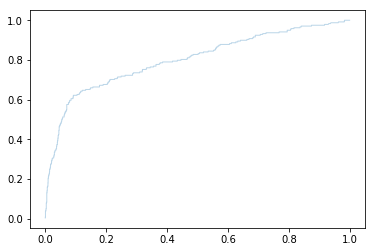

Plot feature importances...


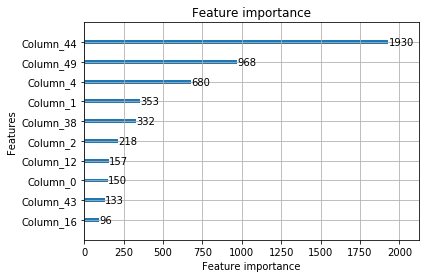

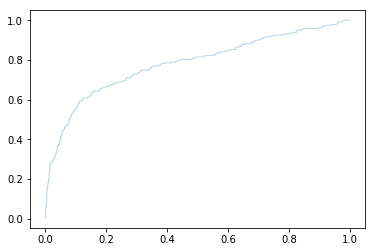

Plot feature importances...


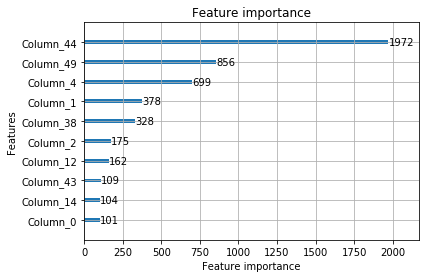

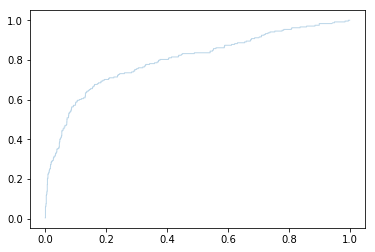

Plot feature importances...


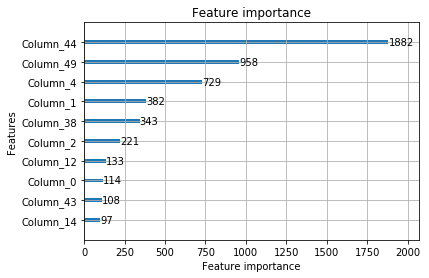

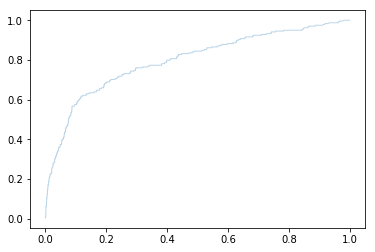

Plot feature importances...


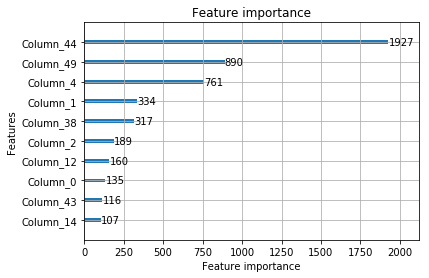

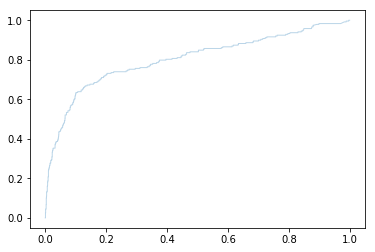

Plot feature importances...


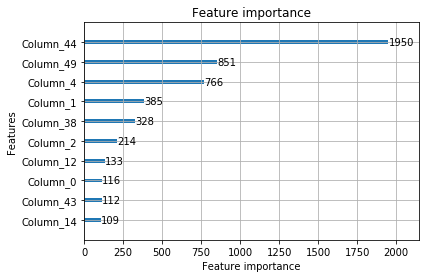

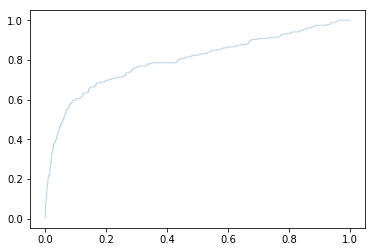

Plot feature importances...


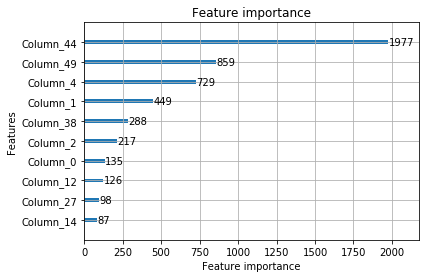

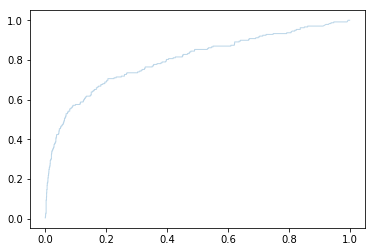

Plot feature importances...


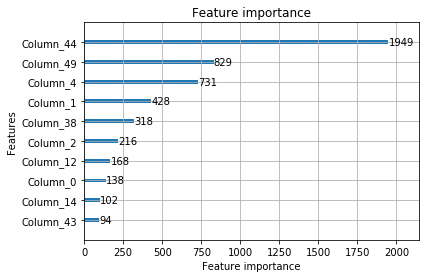

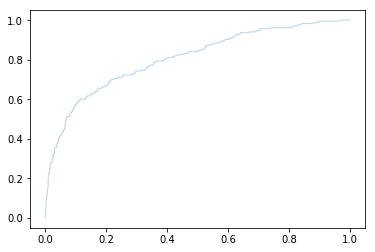

Plot feature importances...


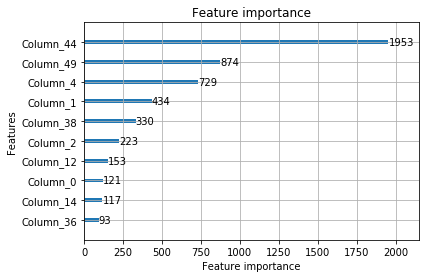

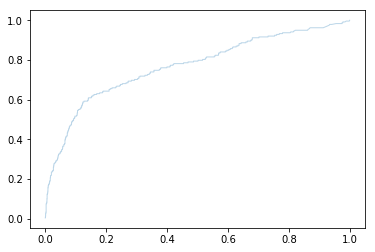

Plot feature importances...


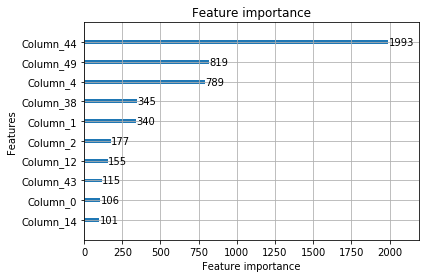

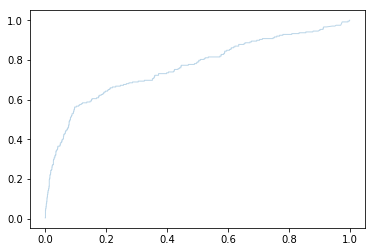

Plot feature importances...


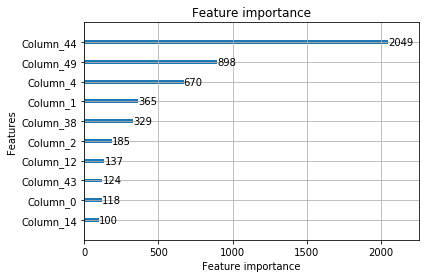

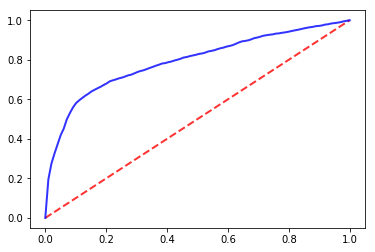

In [10]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0
# boosting_type: 'dart'
# colsample_bytree: 0.9
# is_unbalance: True
# learning_rate: 0.032359365692961224
# metric: 'auc'
# n_estimators: 400
# num_leaves: 16
# objective: 'binary'
# reg_alpha: 0
# reg_lambda: 0
# subsample: 0.75
model = lgb.LGBMClassifier(
                            colsample_bytree= 0.9, learning_rate=0.03,
                            boosting_type= 'dart',subsample= 0.75,
                            num_boosting_rounds=256, metric='auc',
                            n_estimators=400, reg_lambda=0, reg_alpha=0, num_leaves=16
)
# train
for train, test in cv.split(X, Y):
    lgb_train = lgb.Dataset(X[train], Y[train])
    lgb_eval = lgb.Dataset(X[test], Y[test], reference=lgb_train)
    
#     gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=128,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=32
#                    )
    y_pred = model.fit(X[train], Y[train]).predict_proba(X[test])[:, 1]
#     y_pred = gbm.predict(X[test], num_iteration=gbm.best_iteration)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()
    
    print('Plot feature importances...')
    ax = lgb.plot_importance(model, max_num_features=10)
    plt.show()


    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

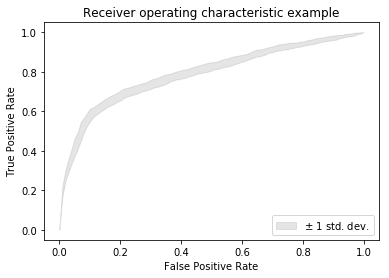

0.79152719297383145

In [11]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
n_iter=8
param_dist = {
    'task': ['train'],
    'boosting_type': ['gbdt', 'dart'],
#     'boosting_type': ['dart'],
    'objective': ['binary'],
    'metric': ['auc'],
    'num_leaves': 2 ** np.arange(4, 7, 1),
    'learning_rate': 10 ** np.arange(-2.5, -1, 0.01),
    'colsample_bytree': np.arange(0.7, 1.0, 0.05),
    'subsample': np.arange(0.7, 1.0, 0.05),
#     'bagging_freq': 2 ** np.arange(4, 8, 1),
    'verbose': [0],
    'n_estimators': [200,300,400,500,600],
    'colsample_bytree' : [0.7,0.8,0.9,1],
#     'subsample' : [0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
estimator = lgb.LGBMClassifier(nthread=4,silent=False)#,categorical_feature=[list(X_train).index(catFeature) for catFeature in categorical_features])
clf = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter,cv=5,scoring='roc_auc')



In [14]:
clf.fit(X,Y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, nthread=4,
        num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
          fit_params={}, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'task': ['train'], 'boosting_type': ['gbdt', 'dart'], 'objective': ['binary'], 'metric': ['auc'], 'num_leaves': array([16, 32, 64]), 'learning_rate': array([ 0.00316,  0.00324, ...,  0.0955 ,  0.09772]), 'colsample_bytree': [0.7, 0.8, 0.9, 1], 'subsample': array([ 0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ]), 'verbose': [0], 'n_estimators': [200, 300, 400, 500, 600], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 1, 2, 5, 6, 7, 9, 10], 'is_unbal

In [15]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(X_test.as_matrix())[:,1]

Raw AUC score: 0.791153787877
boosting_type: 'dart'
colsample_bytree: 1
is_unbalance: False
learning_rate: 0.025118864315094691
metric: 'auc'
n_estimators: 600
num_leaves: 16
objective: 'binary'
reg_alpha: 1
reg_lambda: 7
subsample: 0.95000000000000018
task: 'train'
verbose: 0


/usr/lib64/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [16]:
model = lgb.LGBMClassifier(nthread=4,silent=False, bagging_fraction= 0.8, bagging_freq= 16,
                                boosting_type= 'dart',colsample_bytree= 0.8,feature_fraction= 0.8,
                                is_unbalance= False, num_boosting_rounds=256)
lgb_train = lgb.Dataset(X, Y)
    
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=256,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=32
                   )
test_probs = gbm.predict(X_test.as_matrix(), num_iteration=gbm.best_iteration)
# test_probs = model.predict_proba(X_test.as_matrix())[:,1]
test_indices = X_test.index.values
results = pd.DataFrame({'id':test_indices, 'y':test_probs})
results_sorted = results.sort_values(['id'])
results_sorted.to_csv('lightgbm.csv', index=False)

NameError: name 'params' is not defined